# Predicting customer behavior through supervised learning

Beta Bank's customers are leaving, each month, little by little. Bankers discovered that it is cheaper to save existing customers than to attract new ones.

## Contents <a id='back'></a>

* [Intro](#intro)
* [Stage 1. Data loading](#data_loading)
    * [1.1 Data exploration](#explore_data)
    * [1.2 Graphical data exploration](#graphical_explore)
* [Stage 2. Data preprocessing](#data_preprocessing)
* [Stage 3. Data division](#data_division)
* [Stage 4. Model training (1st intent)](#model_training_1)
* [Stage 5. Model improvement (1st intent)](#model_improvement_1)
    * [5.1 Balanced method](#balanced_method)
    * [5.2 Upsampling method](#upsampling)
    * [5.3 Downsampling method](#downsampling)
* [Stage 6. Model training (2nd intent)](#model_training_2)
* [Stage 7. Model improvement (2nd intent)](#model_improvement_2)
* [Stage 8. Model training (3rd intent)](#model_training_3)
* [Stage 9. Model improvement (3rd intent)](#model_improvement_3)
    * [9.1 Balanced method](#balanced_method_tree)
    * [9.2 Upsampling method](#upsampling_tree)
    * [9.3 Downsampling method](#downsampling_tree)
    * [9.4 Hyperparameters changing](#hyperparameter_chang)
* [Stage 10. Model testing](#model_testing)
* [Stage 11. ROC curve](#roc)
* [Stage 12. Guidelines](#guidelines)
* [Conclusion](#conclusion)

## Introduction <a id='intro'></a>

We need to predict if a customer will leave the bank soon. We have the data of the past behavior of customers and the termination of contracts with the bank.

## Stage 1. Data loading <a id='data_loading'></a>

In [1]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
# Load the data files into DataFrame
try:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')
except:
    df = pd.read_csv('/datasets/Churn.csv')

### 1.1 Data exploration <a id='explore_data'></a>

In [3]:
# printing the general/summary information about the df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
# printing the first rows
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


The dataset contains the following fields:
- `RowNumber` — data index
- `CustomerId` — unique customer identifier
- `Surname` 
- `CreditScore` — credit value
- `Geography` — country of residence
- `Gender` 
- `Age` 
- `Tenure` — period during which a client's deposit has matured (years)
- `Balance` — account balance
- `NumOfProducts` — number of banking products used by the customer
- `HasCrCard` — the customer has a credit card (1 - yes; 0 - no)
- `IsActiveMember` — client activity (1 - yes; 0 - no)
- `EstimatedSalary`
- `Exited` — The client has left (1 - yes; 0 - no). This is our target

In [5]:
# checking for any duplicated rows
df.duplicated().sum()

0

In [6]:
# printing descriptive statistics
df.describe().astype('int')

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000,10000,10000,10000,9091,10000,10000,10000,10000,10000,10000
mean,5000,15690940,650,38,4,76485,1,0,0,100090,0
std,2886,71936,96,10,2,62397,0,0,0,57510,0
min,1,15565701,350,18,0,0,1,0,0,11,0
25%,2500,15628528,584,32,2,0,1,0,0,51002,0
50%,5000,15690738,652,37,5,97198,1,1,1,100193,0
75%,7500,15753233,718,44,7,127644,2,1,1,149388,0
max,10000,15815690,850,92,10,250898,4,1,1,199992,1


So, df is a 10000 rows and 14 columns dataframe with null values only in 'Tenure' column, no duplicated rows and apparently no unusual values inside it. Types of columns is coherent with their info.

### 1.2 Graphical data exploration <a id='graphical_explore'></a>

In order to be better aware of what the data include, lets run a graphical data exploration.

For features ('CreditScore', 'Geography', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary') we will plot some histograms and barchart (depending if the feature is numerical or categorical). For the target ('Exited'), a bar chart would do the job. Finally, in order to relate the features to the target, we make some boxplot.

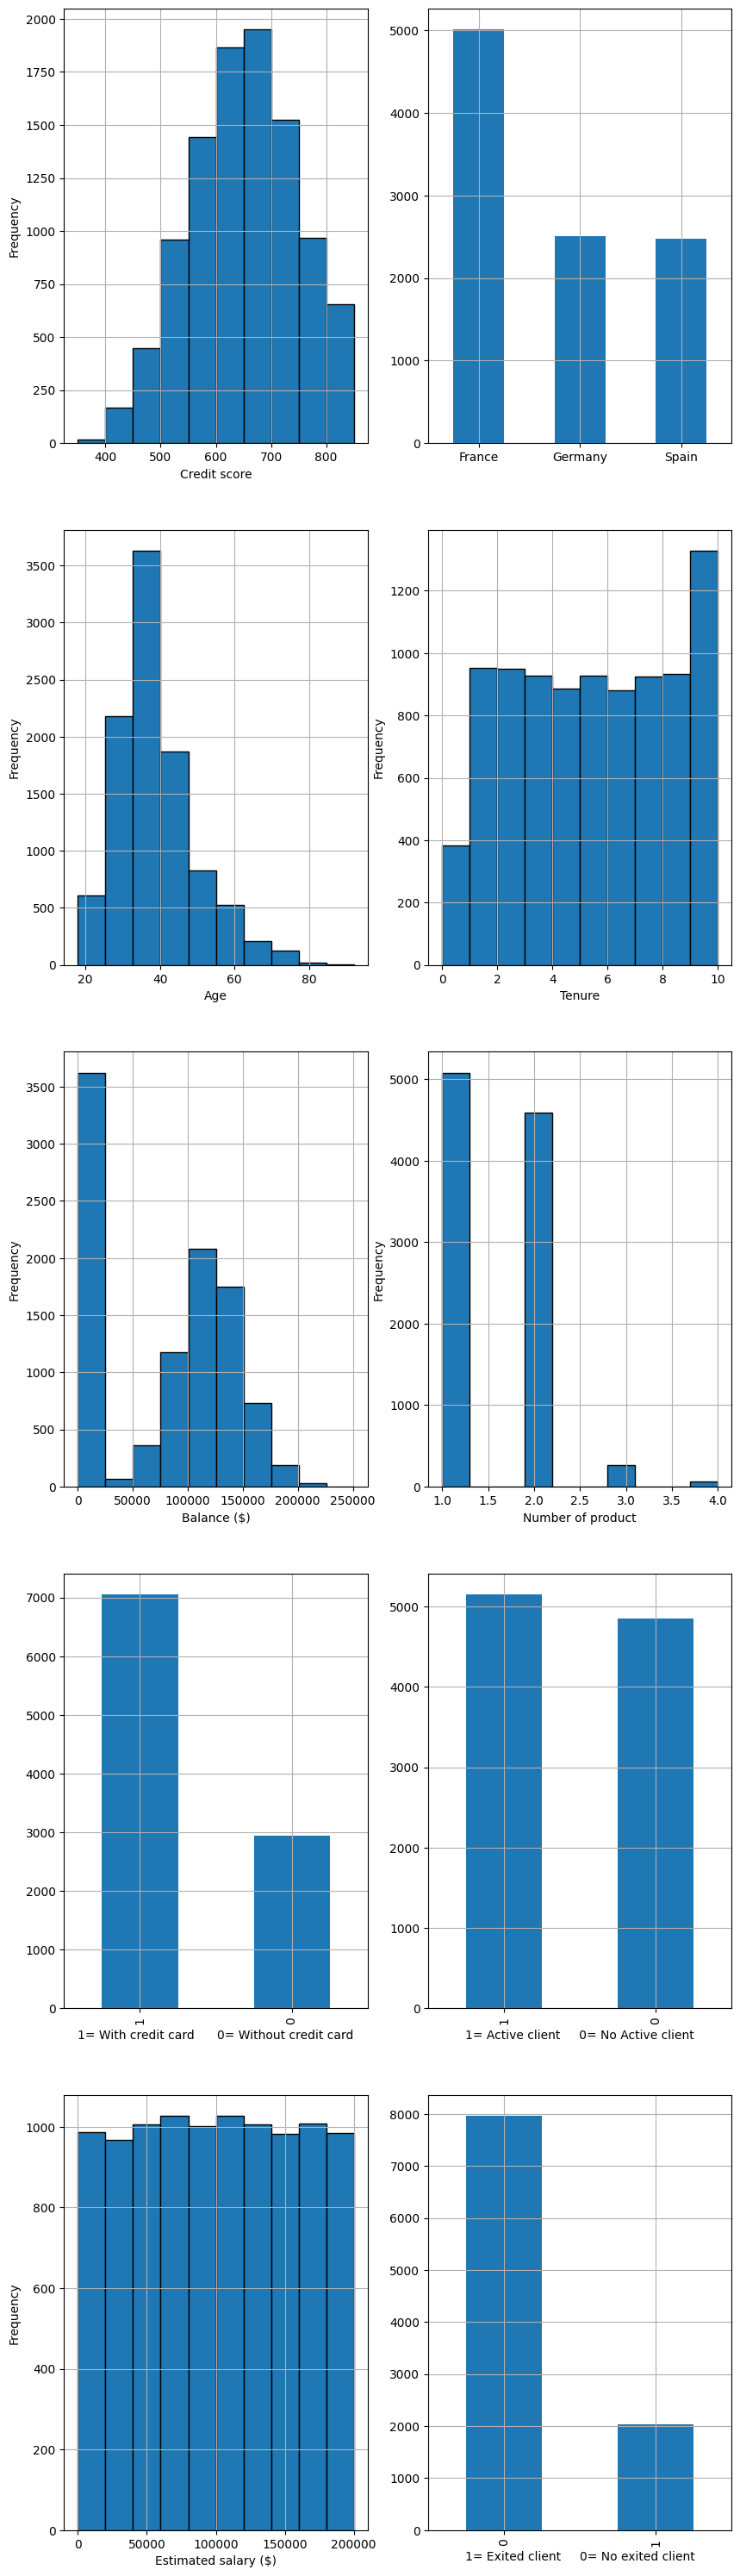

In [7]:
fig, axes = plt.subplots(figsize=(10,38),nrows=5, ncols=2)

df['CreditScore'].plot(ax=axes[0,0], kind='hist', edgecolor = 'black', grid=True).set_xlabel('Credit score')
df['Geography'].value_counts().plot(ax=axes[0,1], kind='bar', grid=True, rot=0)
df['Age'].plot(ax=axes[1,0], kind='hist', edgecolor = 'black', grid=True).set_xlabel('Age')
df['Tenure'].plot(ax=axes[1,1], kind='hist', edgecolor = 'black', grid=True).set_xlabel('Tenure')
df['Balance'].plot(ax=axes[2,0], kind='hist', edgecolor = 'black', grid=True).set_xlabel('Balance ($)')
df['NumOfProducts'].plot(ax=axes[2,1], kind='hist', edgecolor = 'black', grid=True).set_xlabel('Number of product')
df['HasCrCard'].value_counts().plot(ax=axes[3,0], kind='bar', grid=True).set_xlabel('1= With credit card      0= Without credit card')
df['IsActiveMember'].value_counts().plot(ax=axes[3,1], kind='bar', grid=True).set_xlabel('1= Active client     0= No Active client')
df['EstimatedSalary'].plot(ax=axes[4,0], kind='hist', edgecolor = 'black', grid=True).set_xlabel('Estimated salary ($)')
df['Exited'].value_counts().plot(ax=axes[4,1], kind='bar', grid=True).set_xlabel('1= Exited client     0= No exited client')

plt.show()

So, we can see that many customers have a credit score above 1000, most of them are french and around 35 years of age. Almost of them hold the bank account for more than a year. More than a third of them has no money in the bank account. Half of the customers use one or two products. 70% of customers have credit card, more than 50% are active clients. Half of customers have an estimated salary over 100k. 20% of them abandoned the bank.

And now, as said above, in order to relate the features to the target, we make some boxplot.

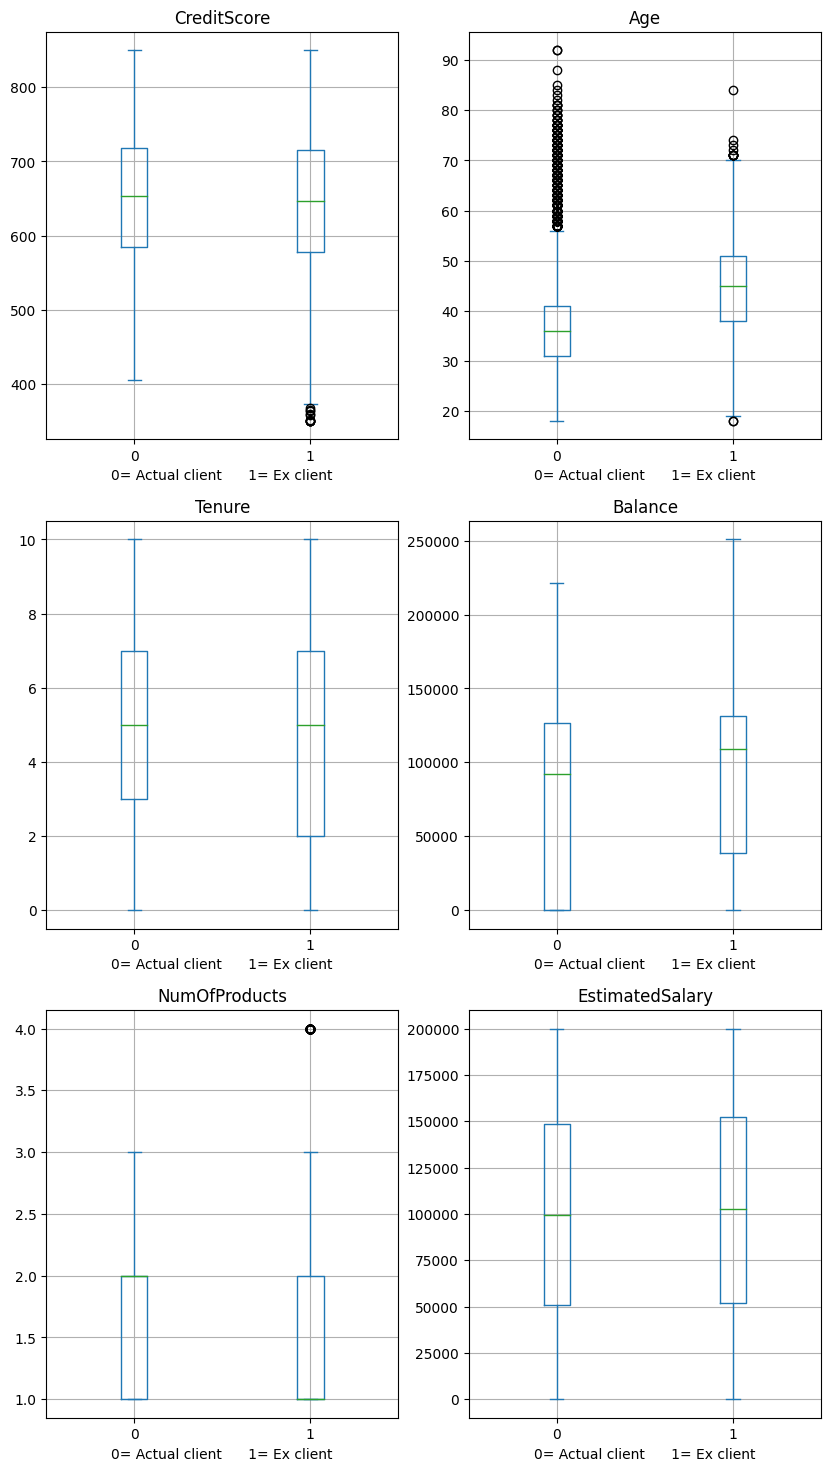

In [8]:
fig, axes = plt.subplots(figsize=(10, 18), nrows=3, ncols=2)

df.plot(ax=axes[0,0], kind='box', column='CreditScore', by='Exited', grid=True, xlabel='0= Actual client      1= Ex client')
df.plot(ax=axes[0,1], kind='box', column='Age', by='Exited', grid=True, xlabel='0= Actual client      1= Ex client')
df.plot(ax=axes[1,0], kind='box', column='Tenure', by='Exited', grid=True, xlabel='0= Actual client      1= Ex client')
df.plot(ax=axes[1,1], kind='box', column='Balance', by='Exited', grid=True, xlabel='0= Actual client      1= Ex client')
df.plot(ax=axes[2,0], kind='box', column='NumOfProducts', by='Exited', grid=True, xlabel='0= Actual client      1= Ex client')
df.plot(ax=axes[2,1], kind='box', column='EstimatedSalary', by='Exited', grid=True, xlabel='0= Actual client      1= Ex client')
plt.show()

First thing that jumps to the eyes is that, except for Age and Credit Score, there are not outliers. Other important characteristic is that, except for Age and Number of product, median values of both (exited and no exited clients) are pretty close between them.

Before training a model, it is a good practice to see what feature has more "weight" on the target, in our case the variable "Exited". So we use a correlation matrix to do it:

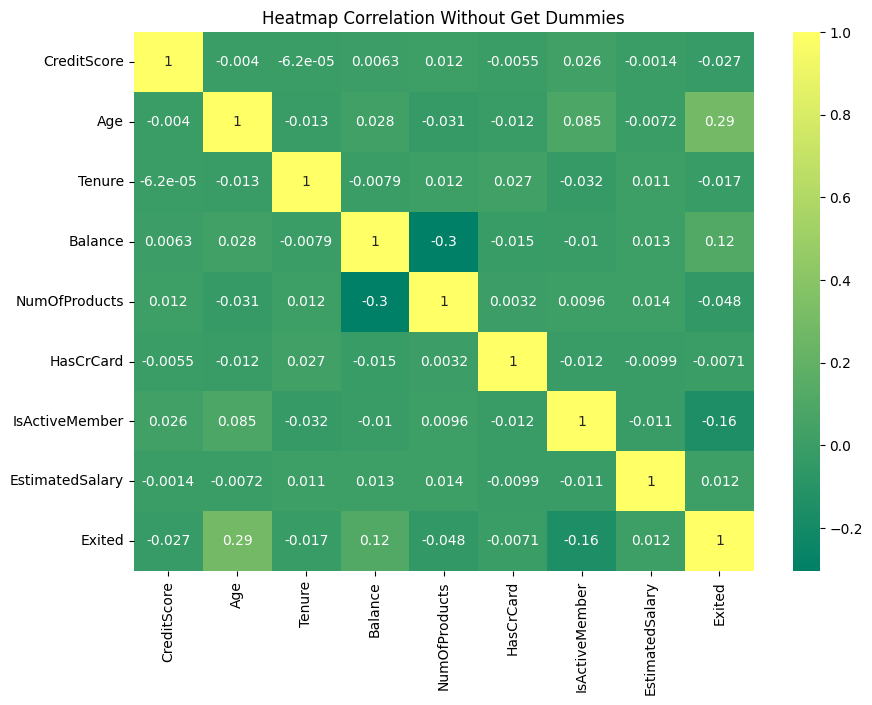

In [9]:
plt.figure(figsize = (10,7))
df_corr = df.drop(['RowNumber', 'CustomerId', 'Surname', 'Geography', 'Gender'], axis='columns')
sns.heatmap(df_corr.corr(), annot = True, cmap = 'summer')
plt.title('Heatmap Correlation Without Get Dummies')
plt.show()

In [10]:
df_corr.corr()['Exited'].sort_values(ascending = False)

Exited             1.000000
Age                0.285323
Balance            0.118533
EstimatedSalary    0.012097
HasCrCard         -0.007138
Tenure            -0.016761
CreditScore       -0.027094
NumOfProducts     -0.047820
IsActiveMember    -0.156128
Name: Exited, dtype: float64

So, we see that, for now, "Age" is the most influencing feature on "Exited". We will confirm this later.

## Stage 2. Data preprocessing <a id='data_preprocessing'></a>

First thing we should do is to find a way to replace the null values in 'tenure' column. The most reasonable way to replace the null values is with the mean value of the corresponding Age. 

In [11]:
def my_lambda(x):
    return x.fillna(x.mean())

df['Tenure'] = df.groupby(['Age'])['Tenure'].transform(lambda x: my_lambda(x)).astype(int)

Ok ! Lets see the resulting column info

In [12]:
df['Tenure'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 10000 entries, 0 to 9999
Series name: Tenure
Non-Null Count  Dtype
--------------  -----
10000 non-null  int32
dtypes: int32(1)
memory usage: 39.2 KB


Ok ! we have now 10000 int values in 'Tenure'

Other remark is that the column 'Surname', 'CustomerId' and 'RowNumber' are not important because they are not variables as such, but identifiers and have nothing to be related to any data.

In [13]:
# dropping a unnecessary column
df = df.drop(['Surname', 'CustomerId', 'RowNumber'], axis=1)

Before train the model, lets check something out:

In [14]:
# printng the type of columns
print(df.dtypes)

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int32
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object


Our algorithms use formula that consists of numerical characteristics but, in addition to numerical, our dataframe contains categorical features (Geography and Gender) and this may cause problems. We are going to use the One Hot Encoding technique to transfor categorical features into numerical

In [15]:
# creating a new dataframe using OHE
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


We have now a new column for every unique value in a old categorical column. We also added 'drop_first=True' that allow to drop a column when is unnecessary

## Stage 3. Data division <a id='data_division'></a>

What we are going to do now is splitting our dataframe (df_ohe) in 3 sets:
- training set (3/5 of our data)
- validation set (1/5 of our data)
- test set (1/5 of our data)

Since a multiple split is not possible, we will do 2 steps of splitting. First one is between df_train and df_valid with a 60/40 rule and second one is between df_valid and df_test with a 50/50 rule. This means that at the end, the original dataframe is splitted df_train 60%, df_valid 20% and df_test 20%.

Anyway, first of all, let's set what the features and target are:

In [16]:
# declaring variables
features = df_ohe.drop('Exited', axis=1)
target = df_ohe['Exited']

In [17]:
# Splitting training set from validation set (60/40)
feature_train, feature_valid, target_train, target_valid = train_test_split(features, target, test_size = 0.40, random_state=12345)

In [18]:
# Splitting validation set from test set (50/50)
feature_valid, feature_test, target_valid, target_test = train_test_split(feature_valid, target_valid, test_size = 0.50, random_state=12345)

In [19]:
print('Size of the training set "feature_train" is:', feature_train.shape)
print('Size of the validation set "feature_valid" is:', feature_valid.shape)
print('Size of the test set "feature_test" is:', feature_test.shape)

Size of the training set "feature_train" is: (6000, 11)
Size of the validation set "feature_valid" is: (2000, 11)
Size of the test set "feature_test" is: (2000, 11)


## Stage 4. Model training (1st intent) <a id='model_training_1'></a>

Since the technique OHE does not work perfectly for TreeClassifier, we are going to use a LogisticRegression algorithm:

In [20]:
# initialize and train the model
model = LogisticRegression(random_state = 12345, solver='liblinear')
model.fit(feature_train, target_train)
predicted_valid = model.predict(feature_valid)

print('Accuracy:', accuracy_score(target_valid, predicted_valid))
print('F1 Score:', f1_score(target_valid, predicted_valid))
print()
print(confusion_matrix(target_valid, predicted_valid))

Accuracy: 0.7815
F1 Score: 0.08385744234800838

[[1543   39]
 [ 398   20]]


The accuracy (meaning the percentage of right prediction) is 78%. Is this enough?   From the confusion matrix we also see that this model is quite pessimistic because we often see negative responses where we shouldn't (false negatives, bottom-right). Futhermore, F1-score is close to zero and this is a negative sign.

We have to check how often the target contains "1" or "0".

In [21]:
# printing the class frequency in 'Exited' column
print(df_ohe['Exited'].value_counts(normalize = True))

0    0.7963
1    0.2037
Name: Exited, dtype: float64


So, in the 'Exited' column there are ~80% of zeros and ~20% of ones. We should now see how often the prediction_valid contains "1" or "0".

In [22]:
# printing the class frequency in predicted_valid
predicted_valid = pd.Series(model.predict(feature_valid))
print(predicted_valid.value_counts(normalize = True))

0    0.9705
1    0.0295
dtype: float64


So, 'predicted_valid' contains 97% of zeros. We can say then that we almost have a constant model, meaning a model that predicts always the same number.

The accuracy of the logistic regression is almost the same of the constant model. This means that there is a strong class imbalance in our target, which affects how the model is trained. So, next step will be work this imbalance out.

## Stage 5. Model improvement (1st intent) <a id='model_improvement_1'></a>

The aim is to achieve a F1 score of at least 0.59. First thing we should do, since our features have different scales, we have to normalize the their range.

In [23]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(feature_train[numeric])
feature_train[numeric] = scaler.transform(feature_train[numeric])
feature_valid[numeric] = scaler.transform(feature_valid[numeric])
feature_test[numeric] = scaler.transform(feature_test[numeric])

feature_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,-0.886751,-0.373192,1.096447,1.232271,-0.891560,1,0,-0.187705,0,1,1
3411,0.608663,-0.183385,1.096447,0.600563,-0.891560,0,0,-0.333945,0,0,0
6027,2.052152,0.480939,-0.717561,1.027098,0.830152,0,1,1.503095,1,0,1
1247,-1.457915,-1.417129,0.370844,-1.233163,0.830152,1,0,-1.071061,0,0,1
3716,0.130961,-1.132419,-1.080363,1.140475,-0.891560,0,0,1.524268,1,0,0


As stated before, there is a strong class imbalance. So, next step will be work this imbalance out. To do that we will use two methods:
- Using class_weight = 'balanced' option in a new model
- Using the upsampling technique
- Using the downsampling technique

### 5.1 Balanced method <a id='balanced_method'></a>

In [24]:
model_balanced = LogisticRegression(random_state=12345, solver='liblinear', class_weight = 'balanced')
model_balanced.fit(feature_train, target_train)
predicted_valid = model_balanced.predict(feature_valid)

print('F1:', f1_score(target_valid, predicted_valid))
print('Accuracy:', accuracy_score(target_valid, predicted_valid))
print(confusion_matrix(target_valid, predicted_valid))

F1: 0.4901456726649529
Accuracy: 0.7025
[[1119  463]
 [ 132  286]]


Easy as this! Now the F1 score is more decent but not yet 0.59. It is curious that the accuracy decreased. Let's see the second method

### 5.2 Upsampling method <a id='upsampling'></a>

The second method consists in making the observations of the rare class (those with 1 in target column) less rare in the dataframe. To do so we follow these steps:

In [25]:
# dividing the training sample into negative and positive observations
features_zeros = feature_train[target_train == 0]
features_ones = feature_train[target_train == 1]
target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]

In [26]:
n_rep = []
f1_score_up = []
acc_up =[]
best_f1 = 0

for repeat in range (1,6):
    # multiplying the positive class observations and combine them with the negative ones
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    # shuffling the data
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state = 12345)

    # training the model with the new data
    model_upsampled = LogisticRegression(solver='liblinear', random_state = 12345)
    model_upsampled.fit(features_upsampled, target_upsampled)
    predicted_valid = model_upsampled.predict(feature_valid)
    F1_score = f1_score(target_valid, predicted_valid)
    acc = accuracy_score(target_valid, predicted_valid)

    n_rep.append(repeat)
    f1_score_up.append(F1_score)
    acc_up.append(acc)
    print('Multiplier = {:.2f} | F1 = {:.3f}, Accuracy = {:.3f}'.format(repeat, F1_score, acc))
    if F1_score > best_f1:
        best_f1 = F1_score
print()
print('Best F1 score is:', best_f1)

Multiplier = 1.00 | F1 = 0.331, Accuracy = 0.802
Multiplier = 2.00 | F1 = 0.466, Accuracy = 0.783
Multiplier = 3.00 | F1 = 0.499, Accuracy = 0.750
Multiplier = 4.00 | F1 = 0.489, Accuracy = 0.702
Multiplier = 5.00 | F1 = 0.485, Accuracy = 0.663

Best F1 score is: 0.4989979959919841


To have a better view, let's plot a graph:

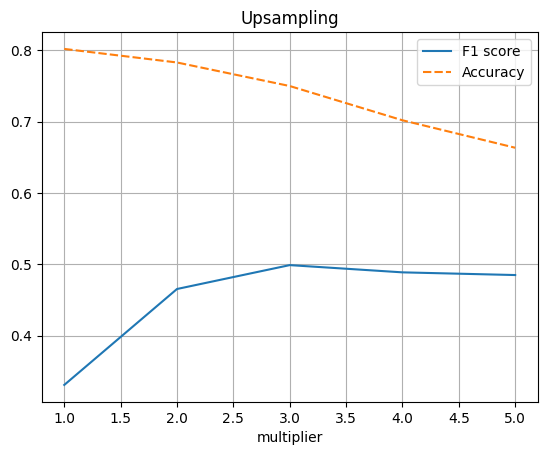

In [27]:
data = pd.DataFrame(columns=['F1 score', 'Accuracy'], index = n_rep)
data['F1 score'] = f1_score_up
data['Accuracy'] = acc_up

sns.lineplot(data = data)
plt.title('Upsampling')
plt.xlabel('multiplier')
plt.grid()
plt.show()

When the multiplying factor is 3, F1-score is highest but not yet 0.59. So, we did not achieve our goal. Let's try the last method:

### 5.3 Downsampling method <a id='downsampling'></a>

The third method consists in making the observations of the frequent class (those with 0 in target column) less frequent in the dataframe. To do so we follow these steps:

In [28]:
n_rep = []
f1_score_down = []
acc_down =[]
best_f1 = 0

for fraction in np.arange(0.2, 0.8, 0.1):
    # splitting the frequent class observations and combine them with the rare ones
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    # shuffling the data
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    
    # training the model with the new data
    model_downsampled = LogisticRegression(solver='liblinear', random_state = 12345)
    model_downsampled.fit(features_downsampled, target_downsampled)
    predicted_valid = model_downsampled.predict(feature_valid)
    F1_score = f1_score(target_valid, predicted_valid)
    acc = accuracy_score(target_valid, predicted_valid)

    
    n_rep.append(fraction)
    f1_score_down.append(F1_score)
    acc_down.append(acc)    
    print('Divider = {:.2f} | F1 = {:.3f}, Accuracy = {:.3f}'.format(fraction, F1_score, acc))
    if F1_score > best_f1:
        best_f1 = F1_score
print()
print('Best F1 score is:', best_f1)

Divider = 0.20 | F1 = 0.479, Accuracy = 0.662
Divider = 0.30 | F1 = 0.497, Accuracy = 0.734
Divider = 0.40 | F1 = 0.503, Accuracy = 0.770
Divider = 0.50 | F1 = 0.468, Accuracy = 0.782
Divider = 0.60 | F1 = 0.424, Accuracy = 0.786
Divider = 0.70 | F1 = 0.391, Accuracy = 0.791
Divider = 0.80 | F1 = 0.370, Accuracy = 0.796

Best F1 score is: 0.5032397408207344


To have a better view, let's plot a graph:

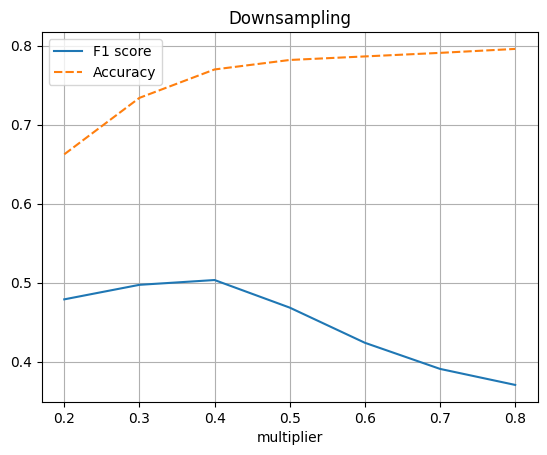

In [29]:
data = pd.DataFrame(columns=['F1 score', 'Accuracy'], index = n_rep)
data['F1 score'] = f1_score_down
data['Accuracy'] = acc_down

sns.lineplot(data = data)
plt.title('Downsampling')
plt.xlabel('multiplier')
plt.grid()
plt.show()

Damn! Even at its highest, F1-score is not going to 0.59. So, we have not achieved the goal.
The reason is: when the multiplier reaches 4, overfitting becomes present in the model. This means that the model starts to perform better on the training data but worse on the validation data.

The idea now is to repeat the same process but this time with another algorithm: RandomForestClassifier

## Stage 6. Model training (2nd intent) <a id='model_training_2'></a>

We try with a basic RandomForestClassifier without touching any hiperparameters:

In [30]:
model_rfc = RandomForestClassifier(random_state = 12345)
model_rfc.fit(feature_train, target_train)
predicted_valid = model.predict(feature_valid)

print('Accuracy:', accuracy_score(target_valid, predicted_valid))
print('F1 Score:', f1_score(target_valid, predicted_valid))
print()
print(confusion_matrix(target_valid, predicted_valid))

Accuracy: 0.6785
F1 Score: 0.4827031375703942

[[1057  525]
 [ 118  300]]


As a first intent, the F1 is really good but we should remind that now we are working with normalized data and this is (in part) the reason why our F1 is already this good.

## Stage 7. Model improvement (2nd intent) <a id='model_improvement_2'></a>

So, we are going to create an iteration loop changing the max-depth and the number of estimators. We should not forget to add class_weight = 'balanced' to our improved model

In [31]:

n_of_trees = []
tree_dep = []
f1_score_rfc = []
best_f1 = 0

best_est = 0
best_depth = 0

for est in range(15, 101, 15):
        for depth in range(1, 5):
                model_rfc = RandomForestClassifier(random_state = 12345, n_estimators= est, max_depth=depth, class_weight = 'balanced')
                model_rfc.fit(feature_train, target_train)
                predicted_valid = model_rfc.predict(feature_valid)
                F1_score = f1_score(target_valid, predicted_valid)
                
                n_of_trees.append(est)
                tree_dep.append(depth)
                f1_score_rfc.append(F1_score)
                print('Estimators = {} | max_depth = {}, F1 = {:.2f}'.format(est, depth, F1_score))
                if F1_score > best_f1:
                        best_f1 = F1_score
print()
print('Best F1 score is: {:.2f}'.format(best_f1))


Estimators = 15 | max_depth = 1, F1 = 0.53
Estimators = 15 | max_depth = 2, F1 = 0.57
Estimators = 15 | max_depth = 3, F1 = 0.56
Estimators = 15 | max_depth = 4, F1 = 0.59
Estimators = 30 | max_depth = 1, F1 = 0.53
Estimators = 30 | max_depth = 2, F1 = 0.57
Estimators = 30 | max_depth = 3, F1 = 0.56
Estimators = 30 | max_depth = 4, F1 = 0.59
Estimators = 45 | max_depth = 1, F1 = 0.54
Estimators = 45 | max_depth = 2, F1 = 0.58
Estimators = 45 | max_depth = 3, F1 = 0.58
Estimators = 45 | max_depth = 4, F1 = 0.60
Estimators = 60 | max_depth = 1, F1 = 0.54
Estimators = 60 | max_depth = 2, F1 = 0.56
Estimators = 60 | max_depth = 3, F1 = 0.58
Estimators = 60 | max_depth = 4, F1 = 0.60
Estimators = 75 | max_depth = 1, F1 = 0.55
Estimators = 75 | max_depth = 2, F1 = 0.57
Estimators = 75 | max_depth = 3, F1 = 0.58
Estimators = 75 | max_depth = 4, F1 = 0.60
Estimators = 90 | max_depth = 1, F1 = 0.54
Estimators = 90 | max_depth = 2, F1 = 0.58
Estimators = 90 | max_depth = 3, F1 = 0.59
Estimators 

Great ! We have achieved our goal. F1 is above 0.59.

At this point, we could go to model testing but let's try anyway the last classification algorhitm: DecisionTreeClassifier

## Stage 8. Model training (3rd intent) <a id='model_training_3'></a>

We try with a basic DecisionTreeClassifier without touching any hiperparameters:

In [32]:
model_dtc = DecisionTreeClassifier(random_state = 12345)
model_dtc.fit(feature_train, target_train)
predicted_valid = model.predict(feature_valid)

print('Accuracy:', accuracy_score(target_valid, predicted_valid))
print('F1 Score:', f1_score(target_valid, predicted_valid))
print()
print(confusion_matrix(target_valid, predicted_valid))

Accuracy: 0.6785
F1 Score: 0.4827031375703942

[[1057  525]
 [ 118  300]]


As a first intent, the F1 is really good, as a matter of fact is the same of the RandomForestClassifier, but we should remind that now we are working with normalized data and this is (in part) the reason why our F1 is already this good. Let's try improve it

## Stage 9. Model improvement (3rd intent) <a id='model_improvement_3'></a>

### 9.1 Balanced method <a id='balanced_method_tree'></a>

In [33]:
model_balanced = DecisionTreeClassifier(random_state=12345, class_weight = 'balanced')
model_balanced.fit(feature_train, target_train)
predicted_valid = model_balanced.predict(feature_valid)

print('Accuracy:', accuracy_score(target_valid, predicted_valid))
print('F1:', f1_score(target_valid, predicted_valid))
print()
print(confusion_matrix(target_valid, predicted_valid))

Accuracy: 0.7835
F1: 0.4751515151515151

[[1371  211]
 [ 222  196]]


Accuracy got a little better but F1 slightly decreased. So, lets try with upsampling

### 9.2 Upsampling method <a id='upsampling_tree'></a>

As stated before, upsampling consists in making the observations of the rare class (those with 1 in target column) less rare in the dataframe

In [34]:
n_rep = []
f1_score_up = []
acc_up =[]
best_f1 = 0

for repeat in range (1,6):
    # multiplying the positive class observations and combine them with the negative ones
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    # shuffling the data
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state = 12345)

    # training the model with the new data
    model_upsampled = DecisionTreeClassifier(random_state = 12345)
    model_upsampled.fit(features_upsampled, target_upsampled)
    predicted_valid = model_upsampled.predict(feature_valid)
    F1_score = f1_score(target_valid, predicted_valid)
    acc = accuracy_score(target_valid, predicted_valid)

    n_rep.append(repeat)
    f1_score_up.append(F1_score)
    acc_up.append(acc)
    print('Multiplier = {:.2f} | F1 = {:.3f}, Accuracy = {:.3f}'.format(repeat, F1_score, acc))
    if F1_score > best_f1:
        best_f1 = F1_score
print()
print('Best F1 score is:', best_f1)

Multiplier = 1.00 | F1 = 0.500, Accuracy = 0.792
Multiplier = 2.00 | F1 = 0.497, Accuracy = 0.792
Multiplier = 3.00 | F1 = 0.471, Accuracy = 0.788
Multiplier = 4.00 | F1 = 0.478, Accuracy = 0.781
Multiplier = 5.00 | F1 = 0.484, Accuracy = 0.788

Best F1 score is: 0.5


To have a better view, let's plot a graph:

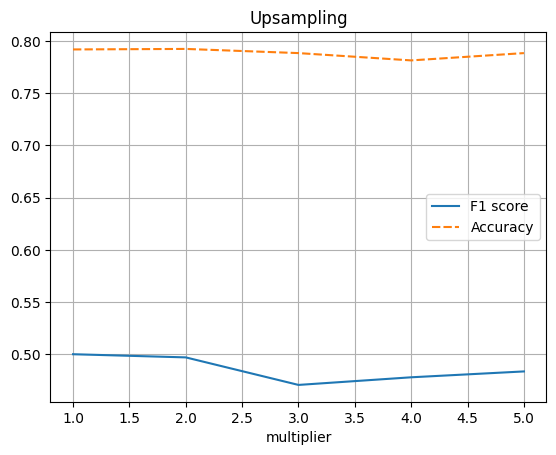

In [35]:
data = pd.DataFrame(columns=['F1 score', 'Accuracy'], index = n_rep)
data['F1 score'] = f1_score_up
data['Accuracy'] = acc_up

sns.lineplot(data = data)
plt.title('Upsampling')
plt.xlabel('multiplier')
plt.grid()
plt.show()

Obviously, upsampling doesn't work. let's do it with downsampling

### 9.3 Downsampling method <a id='downsampling_tree'></a>

As stated before, this method consists in making the observations of the frequent class (those with 0 in target column) less frequent in the dataframe. To do so we follow these steps:

In [36]:
n_rep = []
f1_score_down = []
acc_down =[]
best_f1 = 0

for fraction in np.arange(0.2, 0.8, 0.1):
    # splitting the frequent class observations and combine them with the rare ones
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    # shuffling the data
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    
    # training the model with the new data
    model_downsampled = DecisionTreeClassifier(random_state = 12345)
    model_downsampled.fit(features_downsampled, target_downsampled)
    predicted_valid = model_downsampled.predict(feature_valid)
    F1_score = f1_score(target_valid, predicted_valid)
    acc = accuracy_score(target_valid, predicted_valid)

    
    n_rep.append(fraction)
    f1_score_down.append(F1_score)
    acc_down.append(acc)    
    print('Divider = {:.2f} | F1 = {:.3f}, Accuracy = {:.3f}'.format(fraction, F1_score, acc))
    if F1_score > best_f1:
        best_f1 = F1_score
print()
print('Best F1 score is:', best_f1)

Divider = 0.20 | F1 = 0.473, Accuracy = 0.664
Divider = 0.30 | F1 = 0.505, Accuracy = 0.707
Divider = 0.40 | F1 = 0.490, Accuracy = 0.733
Divider = 0.50 | F1 = 0.510, Accuracy = 0.753
Divider = 0.60 | F1 = 0.506, Accuracy = 0.765
Divider = 0.70 | F1 = 0.513, Accuracy = 0.780
Divider = 0.80 | F1 = 0.509, Accuracy = 0.786

Best F1 score is: 0.5132743362831859


To have a better view, let's plot a graph:

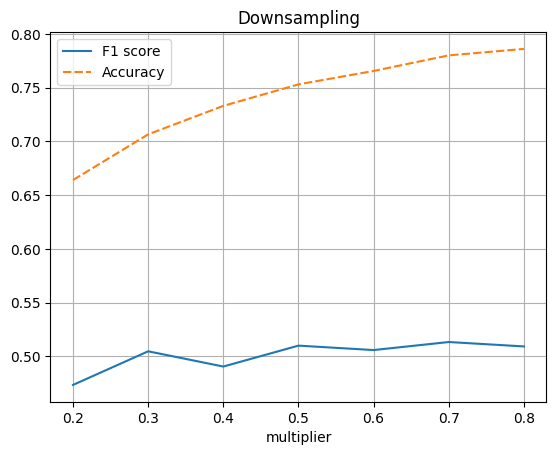

In [37]:
data = pd.DataFrame(columns=['F1 score', 'Accuracy'], index = n_rep)
data['F1 score'] = f1_score_down
data['Accuracy'] = acc_down

sns.lineplot(data = data)
plt.title('Downsampling')
plt.xlabel('multiplier')
plt.grid()
plt.show()

Not at all. Let's try changing the hyperparameter max-depth 

### 9.4 Hyperparameters changing <a id='hyperparameter_chang'></a>

Now we are going to try with differents max-depth and keep the argument "class_weight = 'balanced" in our model

In [38]:
tree_dep = []
f1_score_rfc = []
best_f1 = 0

best_depth = 0

for depth in range(1, 7):
    model_dfc = DecisionTreeClassifier(random_state = 12345, max_depth=depth, class_weight = 'balanced')
    model_dfc.fit(feature_train, target_train)
    predicted_valid = model_dfc.predict(feature_valid)
    F1_score = f1_score(target_valid, predicted_valid)
    
    tree_dep.append(depth)
    f1_score_rfc.append(F1_score)
    print('max_depth = {}, F1 = {:.2f}'.format(depth, F1_score))
    if F1_score > best_f1:
        best_f1 = F1_score
print()
print('Best F1 score is: {:.2f}'.format(best_f1))

max_depth = 1, F1 = 0.50
max_depth = 2, F1 = 0.54
max_depth = 3, F1 = 0.54
max_depth = 4, F1 = 0.53
max_depth = 5, F1 = 0.60
max_depth = 6, F1 = 0.56

Best F1 score is: 0.60


To have a better view, let's plot a graph:

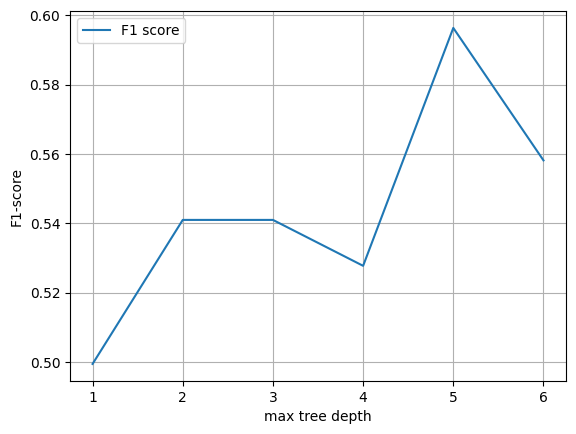

In [39]:
data = pd.DataFrame(columns=['F1 score'], index = tree_dep)
data['F1 score'] = f1_score_rfc

sns.lineplot(data = data)
# plt.title('F1 score')
plt.xlabel('max tree depth')
plt.ylabel('F1-score')
plt.grid()
plt.show()

Cool !! We achieved to get higher of 0.59 with DecisionTree as well.

Anyway, we choose RandomForestClassifier for model testing.

## Stage 10. Model testing <a id='model_testing'></a>

To test if our best model makes accurate predictions even when faced with new data, we are going to use the test set.

In [40]:
predictions_test = model_rfc.predict(feature_test)

def error_count(answers, predictions):
    counter=0
    for i in range(len(target_test)):
        if answers[i] != predictions[i]:
            counter+=1
    return counter

def accuracy(answers, predictions):
    correct = 0
    for i in range(len(answers)):
        if answers[i] == predictions[i]:
            correct+=1
    return correct / len(answers) 

print('Errors:', error_count(target_test.values, predictions_test), 'over', len(target_test), 'observations')
print('Accuracy:', accuracy(target_test.values, predictions_test))

Errors: 439 over 2000 observations
Accuracy: 0.7805


## Stage 11. ROC curve <a id='roc'></a>

The ROC curve (or Receiver Operating Characteristic curve) is a plot that describes the diagnostic ability of a binary classifier as its classification threshold is varied.

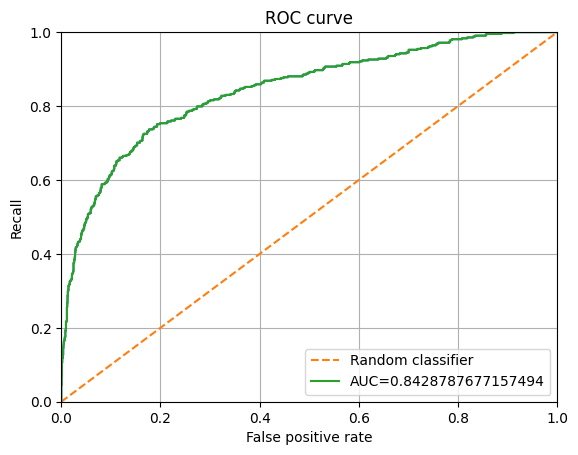

In [41]:
probabilities_valid = model_rfc.predict_proba(feature_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc =  roc_auc_score(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', label = 'Random classifier')
plt.plot(fpr,tpr,label="AUC="+str(auc))

plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False positive rate')
plt.ylabel('Recall')
plt.title('ROC curve')
plt.legend(loc = 'lower right')
plt.show()

In [42]:
print('AUC-ROC score:', roc_auc_score(target_valid, probabilities_one_valid))

AUC-ROC score: 0.8428787677157494


This result is better than the random model, anyway is far from being perfect (AUC-ROC = 1)

## Stage 12. Guidelines <a id='guidelines'></a>

Once arrived at this stage, what we want to know is how important is every feature. In this way we could predict what is the likelihood that a customer leaves.

After training our tree-based model, we have access to the feature_importances_ property. This is one of the fastest ways to obtain feature importances.

In [43]:
target_column = 'Exited'
feature_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male']
# feature_columns = [f for f in df_ohe.columns if f not in target_column]

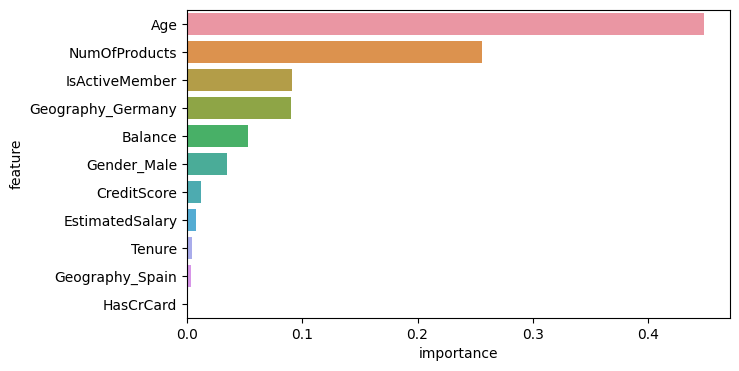

In [44]:
feature_importances = pd.DataFrame(data={"feature": feature_columns, "importance": model_rfc.feature_importances_})

fig, ax = plt.subplots(figsize=(7, 4))

sns.barplot(data=feature_importances.sort_values(by="importance", ascending=False), x="importance", y="feature")
plt.show()

Here we go! 'Age' is by far the most importartant feature to take into account to plan an action oriented to keep customers. Number of product is the 2nd most important. We should remind that we had the feeling about this when we got the boxplots. Anyway, this last is the confirmation.

## Conclusion <a id='conclusion'></a>

We started our project with the aim of predicting when a client is more likely to leave the bank. The bank gave us a csv file with 10000 obseravtions within which there was a significant percentage of clients that have left.

As usual the first thing we did was to explore data, graphically as well. Meking the boxplot allowed us to partially foresee what factors influenced the most the customer departure but anyway we could not yet confirm this before training a reliable model.

So, we splitted our initial dataset in 3 (train, validation and test set) and begun training using LogisticRegression. But, even improving this first model we did not achieve a minimum F1-score of 0.59 (as asked from the management) so we had to change model. We went for RandomForestClassifier and finally got a F1=0.61.

We used this trained model to get a ROC curve and compare it with a random classifier.

Finally, using a tree-based model we got a list of features by importance, proving that 'Age' is the most important feature to consider if we want to tackle the client departure.